In [1]:
#!/usr/bin/python3
# coding: -*- utf-8 -*-
# Tokyo

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel
from urllib.request import urlretrieve

In [3]:
def age2int(age):
    """ 年齢を整数に変換する """
    x = age.replace('-', '-1').replace('代', '').replace('10歳未満', '0').replace('100歳以上', '100').replace('不明', '-1')
    if len(x) == 0:
        return -1
    return int(x)


In [4]:
def code2int(code):
    """ 空文字を不定-1に変換する """
    if len(code) == 0:
        return -1
    return int(code)


In [6]:
# 東京都の OpenData を参照する
patients_file = "130001_tokyo_covid19_patients.csv"
patients_uri = "https://stopcovid19.metro.tokyo.lg.jp/data/"
if not os.path.exists(patients_file):
    urlretrieve(patients_uri + patients_file, patients_file)

In [7]:
patients = []
# CSVデータを整形する
with codecs.open(patients_file, encoding="utf-8") as f:
    l = f.readline()
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 16:
            patients.append(
                [
                    code2int(arr[0]), # No
                    code2int(arr[1]), # code
                    arr[2], # state
                    arr[4], # date
                    arr[5], # day of week
                    arr[7], # live in
                    age2int(arr[8]), # age
                    arr[9], # sex
                    arr[15] # discharge
                ]
            )

print("Total: {}".format(len(patients)))
#print(patients[0])
# 先頭３つのデータは飛ばす
patients = patients[3:]
#print("Total: {}".format(len(patients)))

Total: 25257


In [8]:
# Pandas DataFrame を作成する
df = pd.DataFrame(patients, columns=['No', 'Code', 'State', 'Date', 'DoW', 'LiveIn', 'Age', 'Sex', 'Discharge'])

In [9]:
# Daily の新規感染者を集計する
daily_new = df.groupby('Date').size()
print("Daily New: {}".format(daily_new[-1]))
# duration
frm_date = daily_new.index[0]
end_date = daily_new.index[-1]
print("From: {} To: {}".format(frm_date, end_date))
# moving average by week
ave_mov_days = 7
# 移動平均を算出する
mov_mean = daily_new.rolling(ave_mov_days).mean()
# 4 weeks later
xbins = [dt.strptime(x, "%Y-%m-%d") for x in daily_new.index]
days2pred = 2 * ave_mov_days # 2 weeks
# 4週間先の日付列を取得する
four_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.copy()
xbins_pred.extend(four_weeks_later)
#print(xbins_pred)
#print(xbins[0], xbins[-1], xbins_pred[0], xbins_pred[-1])

Daily New: 144
From: 2020-02-13 To: 2020-09-27


In [10]:
# 決定木-AdaBoost による予測値を算出する
rng = np.random.RandomState(1)
regr_raw = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)
#regr_ave = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)
X = np.arange(0, len(daily_new.index.values))[:, np.newaxis]
#X = np.array(xbins)[:, np.newaxis]
#print(X)
regr_raw.fit(X, daily_new.values)
#regr_ave.fit(X[ave_mov_days-1:], mov_mean[ave_mov_days-1:])
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
y_raw = regr_raw.predict(X_pred)
#y_ave = regr_ave.predict(X_pred)

In [11]:
# ガウス過程回帰による予測値を算出する
#gp_kernel = RBF(111) + ConstantKernel(11) + WhiteKernel(111)
#gp_kernel = RBF(100) + ConstantKernel(10) + WhiteKernel(100)
gp_kernel = RBF(80) + ConstantKernel(10) + WhiteKernel(200)
gpr = GaussianProcessRegressor(kernel=gp_kernel, alpha=1e-1, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, normalize_y=True)
gpr.fit(X, daily_new.values)
y_gpr, y_std = gpr.predict(X_pred, return_std=True)
#print(y_gpr)

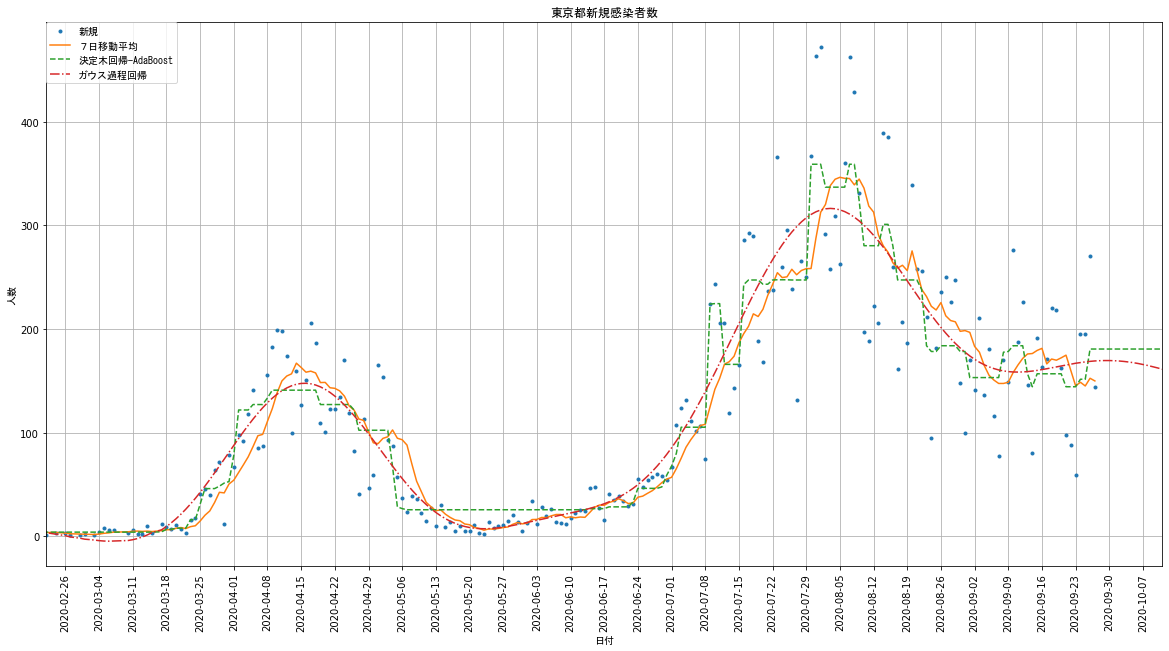

In [12]:
fontname = 'MS Gothic'
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(dates.DayLocator(bymonthday=None, interval=7, tz=None))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m-%d"))
plt.xlim(xbins_pred[ave_mov_days], xbins_pred[-1])
plt.plot(xbins, daily_new, '.', linewidth=1.5)
plt.plot(xbins, mov_mean, '-', linewidth=1.5)
plt.plot(xbins_pred, y_raw, '--', linewidth=1.5)
plt.plot(xbins_pred, y_gpr, '-.', linewidth=1.5)
#plt.plot(xbins_pred, y_ave, '--', linewidth=1)
plt.legend(labels=["新規", "７日移動平均", "決定木回帰-AdaBoost", "ガウス過程回帰"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":fontname})
plt.title('東京都新規感染者数', fontname=fontname)
plt.xlabel('日付', fontname=fontname)
plt.ylabel('人数', fontname=fontname)
plt.grid(True)
plt.xticks(rotation=90, fontsize=10)
plt.show()